<a href="https://colab.research.google.com/github/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/blob/main/DecisionTree_and_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ingest Data

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report 
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/main/company_bankruptcy.csv')

### EDA

In [4]:
y = df['Bankrupt?']
x = df.drop('Bankrupt?', axis=1)

In [31]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.astype(np.float64))

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y, test_size=0.2, random_state=42)

### Models

#### Decsison Tree

accuracy score =  0.9516129032258065
Report:               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1313
           1       0.36      0.39      0.38        51

    accuracy                           0.95      1364
   macro avg       0.67      0.68      0.68      1364
weighted avg       0.95      0.95      0.95      1364



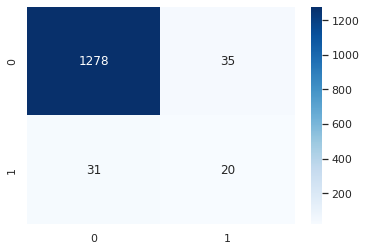

In [35]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)

clfy_pred = clf.predict(x_test)
cm = confusion_matrix(y_test,clfy_pred)

clfa = accuracy_score(y_test, clfy_pred)
print('accuracy score = ', accuracy_score(y_test, clfy_pred))
print("Report:", classification_report(y_test, clfy_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

[Text(0.35977743561030234, 0.96875, 'X[89] <= 0.834\ngini = 0.06\nsamples = 5455\nvalue = [5286, 169]'),
 Text(0.11142217245240761, 0.90625, 'X[34] <= 0.63\ngini = 0.463\nsamples = 192\nvalue = [122, 70]'),
 Text(0.05823068309070549, 0.84375, 'X[8] <= 0.303\ngini = 0.465\nsamples = 49\nvalue = [18, 31]'),
 Text(0.03583426651735722, 0.78125, 'X[55] <= 0.147\ngini = 0.361\nsamples = 38\nvalue = [9, 29]'),
 Text(0.01791713325867861, 0.71875, 'X[46] <= 0.002\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(0.008958566629339306, 0.65625, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.026875699888017916, 0.65625, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.05375139977603583, 0.71875, 'X[35] <= 0.01\ngini = 0.225\nsamples = 31\nvalue = [4, 27]'),
 Text(0.04479283314669653, 0.65625, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.06270996640537514, 0.65625, 'X[69] <= 0.091\ngini = 0.128\nsamples = 29\nvalue = [2, 27]'),
 Text(0.05375139977603583, 0.59375, 'gini = 0.0\nsampl

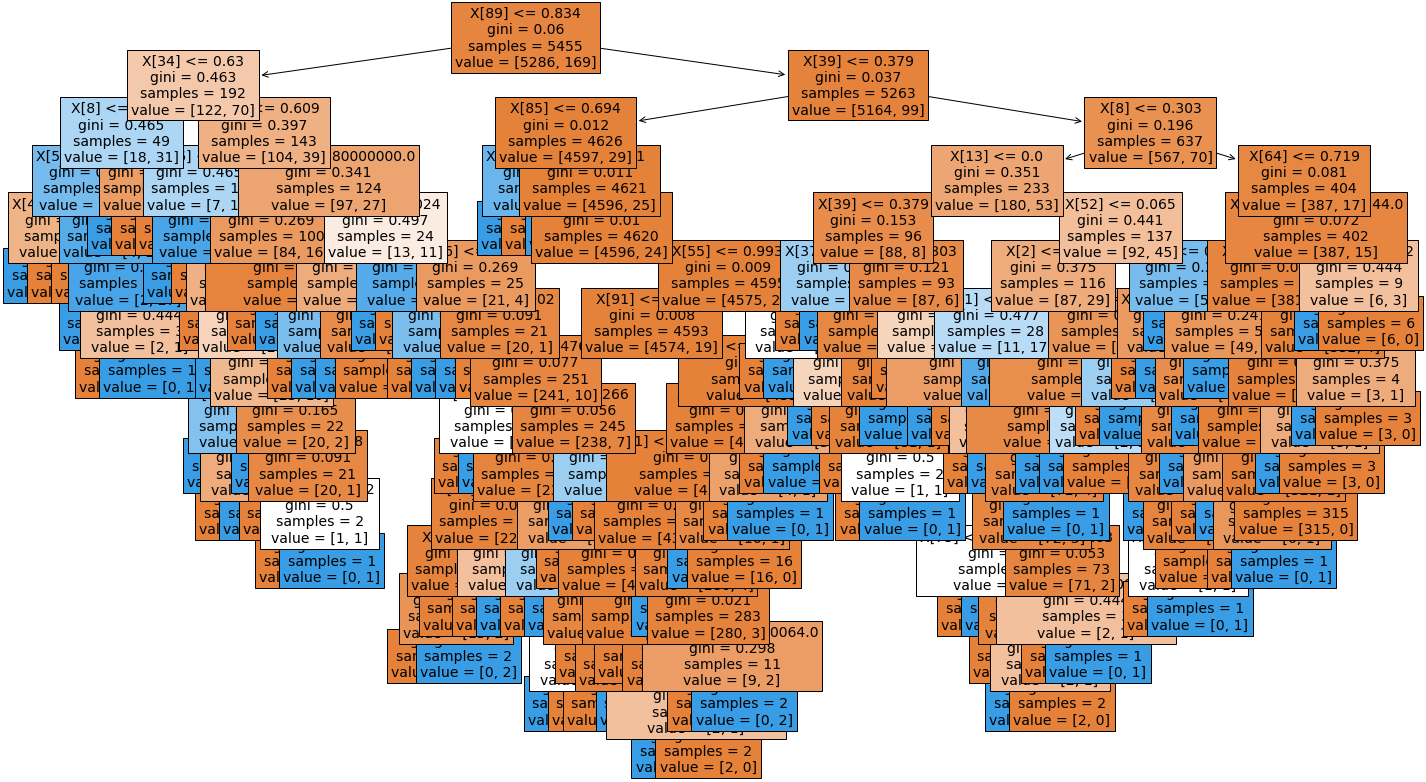

In [20]:
# can adjust min_impurity_decrease=# to decrease the 
from sklearn import tree
%matplotlib inline
plt.figure(figsize=(24,14))
tree.plot_tree(clf, filled=True, fontsize=14)

In [8]:
parameters = [{ 'criterion': ['gini', 'entropy'],
                 'max_depth': range(1,10),
                 'min_samples_split': range(1,10),
                 'min_samples_leaf': range(1,5)}]

grid_search = GridSearchCV(clf, parameters, scoring='accuracy', cv=5, n_jobs=-1)
results = grid_search.fit(x_train, y_train)

print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 254, in fit
    % self.min_samples_split
ValueError: min_samples_split must be an integer greater than 1 or a flo

Mean Accuracy: 0.970
Config: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}


Gini versus Entropy: gini basically measures the randomness of impurity (impurity increases with randomness) whereas entropy measures the uncertainty/randomness (more random, the higher the entropy). Most of the time these produce similar trees but while gini is the default and is often slightly faster, entropy can produce slightly more balanced trees when these two parameters prodcue a difference. 

Max_depth: signifies when the model stops splitting which helps regularize the model to reduce the risk of overfitting. Defualt = 0

Min_samples_leaf: the minimum number of samples a leaf node must have aka a split can only happen if it leaves the minimum about of samples per leaf in both of the resulting nodes. Defualt = 1

Min_samples_split: the minimum number of samples required to split an internal node, if the samle has less than this number it will become a leaf node. Defualt = 2

##### PCA for Feature Selection

In [52]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=95)
pca_test.fit(x_train)
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.135075,0.135075
1,0.211178,0.076103
2,0.263300,0.052122
3,0.314298,0.050999
4,0.360514,0.046215
5,0.396804,0.036290
6,0.431068,0.034264
7,0.462566,0.031498
8,0.492711,0.030145
9,0.514602,0.021890


In [55]:
pca_df.loc[pca_df['Cumulative Variance Ratio'] <= 0.95]

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.135075,0.135075
1,0.211178,0.076103
2,0.263300,0.052122
3,0.314298,0.050999
4,0.360514,0.046215
5,0.396804,0.036290
6,0.431068,0.034264
7,0.462566,0.031498
8,0.492711,0.030145
9,0.514602,0.021890


Using PCA, we have found that 95% of the variance in the data can be explained using 48 of the features. The other 47 features explain only less than 5% of the variance so we can determine that we do not need them in our analysis. 

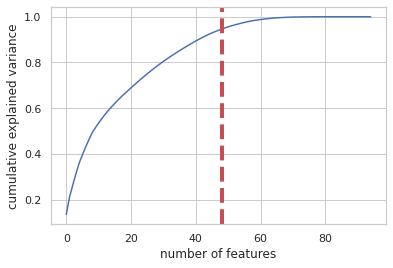

None

In [53]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of features')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=48, ymin=0, ymax=1)
display(plt.show())

In [62]:
pca = PCA(n_components=48)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

accuracy score =  0.9354838709677419
Report:               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1313
           1       0.18      0.20      0.19        51

    accuracy                           0.94      1364
   macro avg       0.57      0.58      0.58      1364
weighted avg       0.94      0.94      0.94      1364



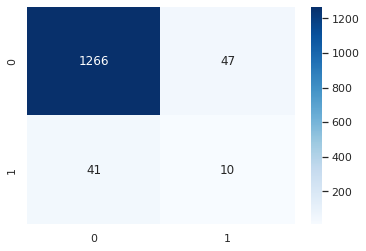

In [63]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train_pca,y_train)

clf2y_pred = clf.predict(x_test_pca)
cm = confusion_matrix(y_test,clf2y_pred)

clfa = accuracy_score(y_test, clf2y_pred)
print('accuracy score = ', accuracy_score(y_test, clf2y_pred))
print("Report:", classification_report(y_test, clf2y_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")